In [2]:
import numpy as np 
import pandas as pd 
import librosa
from librosa import feature
import librosa.display
import matplotlib.pyplot as plt
import os
import keras
from keras.layers import *
from keras import metrics
from keras.utils import to_categorical
import sklearn
from sklearn.model_selection import train_test_split
import csv
import IPython.display as ipd
from keras.regularizers import l1, l2, l1_l2

plt.style.use('ggplot')


In [3]:
random_file_path = './input/genres/rock/rock.00005.wav'

In [4]:
x, sr = librosa.load(random_file_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


### This is a quick feature analysis of a random file in our dataset, ```rock.00005.wav```. This is the raw ```.wav``` file.

In [5]:
ipd.Audio(random_file_path)


### This is a wave plot of the first example file.

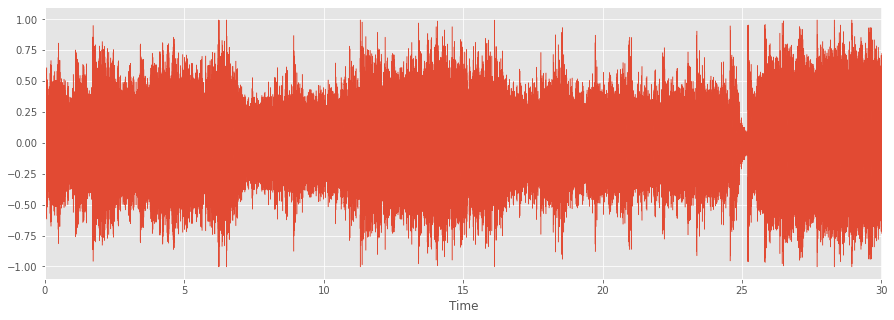

In [6]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

### A chroma vector a a 12-element feature vector of the relative energy of each pitch class in the signal. The following plot is a chromagram of the first example file.

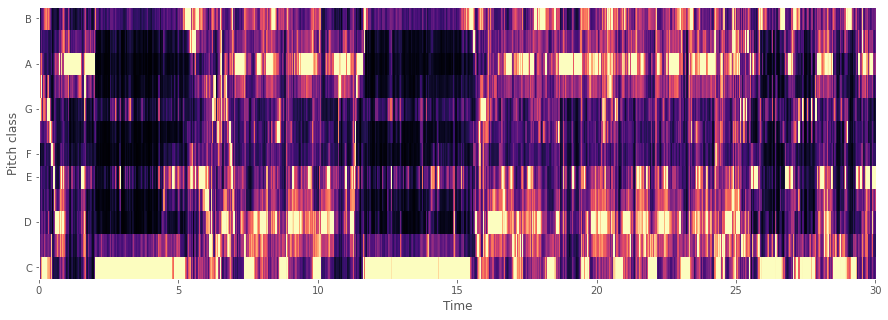

In [7]:
chromagram = librosa.feature.chroma_stft(x, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma')
plt.show()

The RMSE (root mean squared energy) of the signal, defined as

RMSE eqn to be put!

where x(n) is a time signal.

In [8]:
example_rmse = librosa.feature.rms(x)
print(example_rmse.shape)
print(np.mean(example_rmse))

(1, 1293)
0.20384015


### The center of mass of the signal, e.g. the weighted mean of frequencies in the signal.

1542.1318211375356


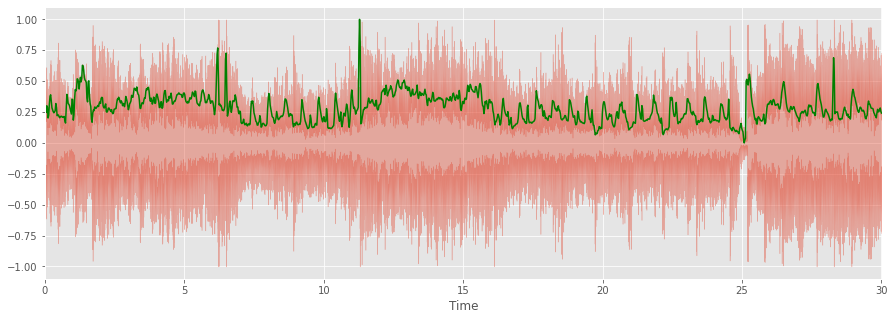

In [9]:
plt.figure(figsize=(15, 5))
example_spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
example_spectral_centroids.shape
frames = range(len(example_spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(example_spectral_centroids), color='g')
print(np.mean(example_spectral_centroids))


Order p spectral bandwidth is defined as

Spectral bandwidth eqn to be put!

where S(k) is the spectral magnitude at frequency bin k, f(k) is the frequency at frequency bin k, and fc is the spectral centroid.

1591.7341647634237


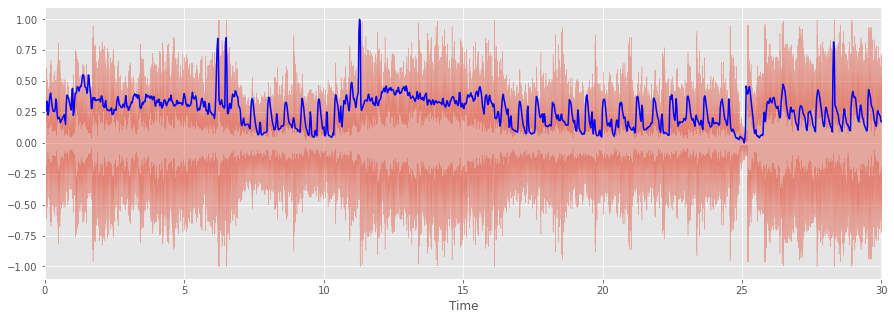

In [10]:
plt.figure(figsize=(15, 5))
example_spectral_bandwidth = librosa.feature.spectral_bandwidth(x, sr=sr)[0]
example_spectral_bandwidth.shape
frames = range(len(example_spectral_bandwidth))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(example_spectral_bandwidth), color='b')
print(np.mean(example_spectral_bandwidth))

### The spectral rolloff is a frequency below which a certain percentage of spectral energy lies.

2869.736475402407


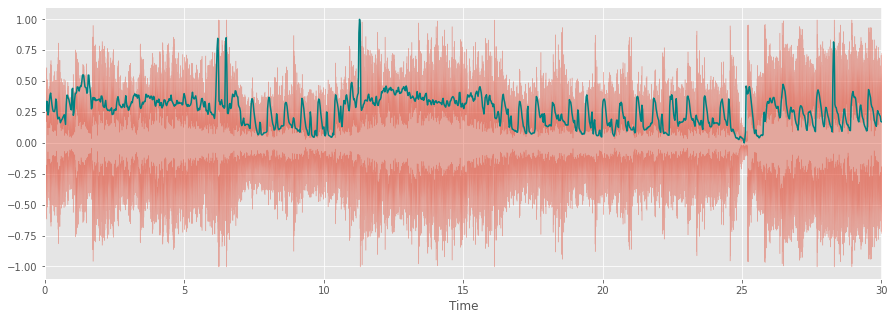

In [11]:
plt.figure(figsize=(15, 5))
example_spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
example_spectral_rolloff.shape
frames = range(len(example_spectral_rolloff))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(example_spectral_bandwidth), color='teal')
print(np.mean(example_spectral_rolloff))

### The zero crossing rate is the rate at which the signal changes sign (crosses y = 0).

8


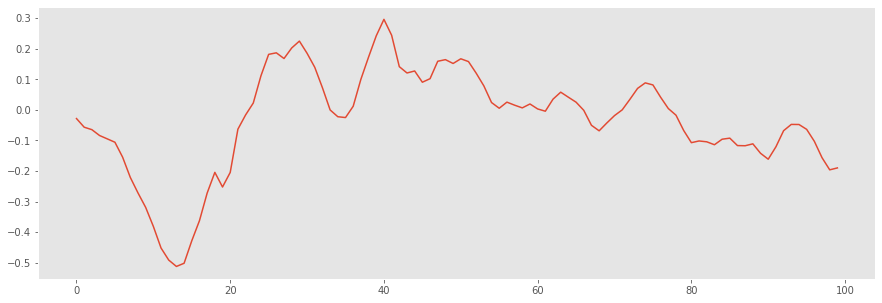

In [12]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(15, 5))
plt.plot(x[n0:n1])
plt.grid()
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

### The Mel-Frequency Cepstral Coefficients (MFCCs) are a set of features which describe the representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

(20, 1293)
1.8776131


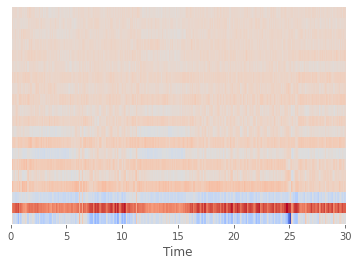

In [13]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
print(np.mean(mfccs))

## Normalizing MFCCs

/usr/local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


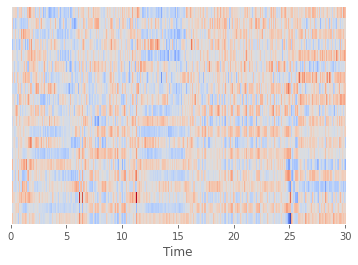

In [15]:
import sklearn
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
# print(mfccs.mean(axis=1))
# print(mfccs.var(axis=1))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## Features we've chosen : Chroma features, RMSE, Spectral Centroid, Spectral Bandwidth, Spectral Rolloff, Zero Crossing Rate, MFCCs

In [10]:
header = 'chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()


## Creating the dataframe.

In [16]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./input/genres/{g}'):
        songname = f'./input/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [4]:
df = pd.read_csv('./data.csv')

In [5]:
df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
blues.00093.wav,0.377690,0.065906,569.930721,995.407125,927.427725,0.021701,-350.436188,169.545746,31.820370,16.682835,...,1.821690,-5.970891,-5.259567,-0.229211,-1.776850,-3.713751,0.181591,2.072390,-2.896225,blues
blues.00087.wav,0.336773,0.158098,1442.190271,1870.534155,3083.414688,0.050889,-155.504929,125.638863,1.596553,45.804523,...,-0.792893,-7.748057,0.413548,-7.030263,3.997679,-6.256611,0.958227,2.019821,-5.742188,blues
blues.00050.wav,0.400860,0.182380,1945.848425,2082.246626,4175.874749,0.085806,-82.979019,107.052124,-25.320452,57.124992,...,12.539581,-9.762303,2.562253,-6.300853,2.996785,-8.718455,-0.326581,-2.980347,0.712600,blues
blues.00044.wav,0.390212,0.136276,2279.124558,2375.102120,5198.360233,0.092570,-109.509285,86.922409,-8.607986,64.494560,...,11.087481,-5.085794,3.976360,-12.859742,12.343859,0.026216,-0.741568,-5.126620,3.303442,blues
blues.00078.wav,0.414188,0.258052,2333.685108,2227.425609,4942.811778,0.123863,-2.524338,101.252716,-33.924385,41.516891,...,12.506608,-13.368823,6.112817,-9.065890,5.033774,-11.330277,3.166534,-4.567591,-4.033623,blues


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, blues.00093.wav to rock.00008.wav
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         1000 non-null   float64
 1   rms                 1000 non-null   float64
 2   spectral_centroid   1000 non-null   float64
 3   spectral_bandwidth  1000 non-null   float64
 4   rolloff             1000 non-null   float64
 5   zero_crossing_rate  1000 non-null   float64
 6   mfcc1               1000 non-null   float64
 7   mfcc2               1000 non-null   float64
 8   mfcc3               1000 non-null   float64
 9   mfcc4               1000 non-null   float64
 10  mfcc5               1000 non-null   float64
 11  mfcc6               1000 non-null   float64
 12  mfcc7               1000 non-null   float64
 13  mfcc8               1000 non-null   float64
 14  mfcc9               1000 non-null   float64
 15  mfcc10              1000 non-null   

In [7]:
df.describe()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.378669,0.130929,2201.834226,2242.559613,4571.702159,0.103637,-144.479170,99.552199,-8.921949,36.293063,...,-6.021121,4.471604,-4.797232,1.781547,-3.870276,1.147988,-3.967431,0.507303,-2.328779,-1.094875
std,0.081706,0.065685,715.961347,526.337663,1574.770035,0.041834,100.235659,31.331904,21.695015,16.666987,...,6.819018,6.717312,6.170919,5.009489,4.874423,4.579110,4.550650,3.869088,3.755574,3.837561
min,0.171782,0.005276,569.930721,897.994319,749.062137,0.021701,-552.064026,-1.527148,-89.901138,-18.768461,...,-28.052265,-15.805227,-27.542309,-12.598773,-17.545473,-15.693589,-17.227766,-11.975698,-18.504187,-19.935202
25%,0.319641,0.086625,1627.793931,1907.136505,3380.956639,0.070281,-200.695129,76.811480,-24.223789,24.107394,...,-10.966826,-0.551576,-9.363372,-1.640080,-7.164838,-1.857098,-7.194296,-2.003978,-4.670281,-3.367999
50%,0.383075,0.122448,2209.468780,2221.408983,4658.671830,0.099539,-120.206070,98.452553,-10.716073,36.957073,...,-5.920161,3.891842,-4.199810,1.879424,-3.614473,1.211945,-4.059109,0.669789,-2.391261,-1.155198
75%,0.435974,0.175793,2691.969702,2578.474352,5534.197785,0.132007,-73.895018,119.893629,5.505793,48.212826,...,-1.004241,9.706133,-0.161017,5.155263,-0.323536,4.350694,-0.842968,3.112519,0.149070,1.303739
max,0.663573,0.398012,4434.439444,3509.578677,8676.405868,0.274829,42.034588,193.096512,56.666088,80.691277,...,17.421038,23.037573,13.054334,18.161661,12.357588,13.468802,11.489994,15.379257,14.686911,15.368967


In [8]:
df['label']

blues.00093.wav    blues
blues.00087.wav    blues
blues.00050.wav    blues
blues.00044.wav    blues
blues.00078.wav    blues
                   ...  
rock.00035.wav      rock
rock.00021.wav      rock
rock.00020.wav      rock
rock.00034.wav      rock
rock.00008.wav      rock
Name: label, Length: 1000, dtype: object

### Mapping the taal names(labels) to integers from 0 to 9(Label Encoding).


In [11]:
d = dict(zip(genres, range(0,10)))
d

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [12]:
df['label']

blues.00093.wav    blues
blues.00087.wav    blues
blues.00050.wav    blues
blues.00044.wav    blues
blues.00078.wav    blues
                   ...  
rock.00035.wav      rock
rock.00021.wav      rock
rock.00020.wav      rock
rock.00034.wav      rock
rock.00008.wav      rock
Name: label, Length: 1000, dtype: object

In [13]:
df['label'] = df['label'].map(d)

In [14]:
df['label']

blues.00093.wav    0
blues.00087.wav    0
blues.00050.wav    0
blues.00044.wav    0
blues.00078.wav    0
                  ..
rock.00035.wav     9
rock.00021.wav     9
rock.00020.wav     9
rock.00034.wav     9
rock.00008.wav     9
Name: label, Length: 1000, dtype: int64

### The following code performs an 75/15/10 (train/validation/test) split on the data after splitting it into train and test data. The order of the data is also randomized. The label data is also changed to one-hot encoding.

In [27]:
X = df.drop('label', axis=1)
y = df['label']

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

"""https://datascience.stackexchange.com/a/53161/73311"""

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

### Creating a Keras Sequential model. The last layer has a softmax activation.

In [32]:
model = keras.models.Sequential()
model.add(Dense(32, input_dim = 26, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(10, activation='softmax'))

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                864       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 29,098
Trainable params: 29,098
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(x_train, y_train,
                    epochs=1000,
                    batch_size=10,
                    shuffle=True,
                    validation_data=(x_val, y_val))

Epoch 1/1000
75/75 [==============================] - 0s 3ms/step - loss: 48.3572 - acc: 0.1240 - val_loss: 13.1836 - val_acc: 0.2067
Epoch 2/1000
75/75 [==============================] - 0s 1ms/step - loss: 10.5497 - acc: 0.1947 - val_loss: 8.4239 - val_acc: 0.2467
Epoch 3/1000
75/75 [==============================] - 0s 1ms/step - loss: 9.7558 - acc: 0.2027 - val_loss: 10.7594 - val_acc: 0.2400
Epoch 4/1000
75/75 [==============================] - 0s 1ms/step - loss: 7.9089 - acc: 0.2200 - val_loss: 4.2694 - val_acc: 0.3067
Epoch 5/1000
75/75 [==============================] - 0s 1ms/step - loss: 6.3721 - acc: 0.2467 - val_loss: 4.3984 - val_acc: 0.3000
Epoch 6/1000
75/75 [==============================] - 0s 1ms/step - loss: 5.1862 - acc: 0.2840 - val_loss: 3.6580 - val_acc: 0.3067
Epoch 7/1000
75/75 [==============================] - 0s 1ms/step - loss: 4.2739 - acc: 0.3027 - val_loss: 3.2894 - val_acc: 0.3400
Epoch 8/1000
75/75 [==============================] - 0s 1ms/step - loss

Epoch 123/1000
75/75 [==============================] - 0s 950us/step - loss: 1.0832 - acc: 0.6853 - val_loss: 1.7353 - val_acc: 0.5333
Epoch 124/1000
75/75 [==============================] - 0s 894us/step - loss: 1.1141 - acc: 0.6560 - val_loss: 1.7326 - val_acc: 0.5067
Epoch 125/1000
75/75 [==============================] - 0s 939us/step - loss: 1.0899 - acc: 0.6787 - val_loss: 1.6240 - val_acc: 0.5667
Epoch 126/1000
75/75 [==============================] - 0s 889us/step - loss: 1.1225 - acc: 0.6613 - val_loss: 1.8068 - val_acc: 0.5133
Epoch 127/1000
75/75 [==============================] - 0s 971us/step - loss: 1.1958 - acc: 0.6373 - val_loss: 1.6462 - val_acc: 0.5067
Epoch 128/1000
75/75 [==============================] - 0s 1ms/step - loss: 1.1563 - acc: 0.6507 - val_loss: 1.6041 - val_acc: 0.5733
Epoch 129/1000
75/75 [==============================] - 0s 979us/step - loss: 1.0433 - acc: 0.6760 - val_loss: 1.5515 - val_acc: 0.5600
Epoch 130/1000
75/75 [============================

Epoch 244/1000
75/75 [==============================] - 0s 969us/step - loss: 0.5548 - acc: 0.8800 - val_loss: 2.6346 - val_acc: 0.5533
Epoch 245/1000
75/75 [==============================] - 0s 929us/step - loss: 0.5945 - acc: 0.8440 - val_loss: 2.4026 - val_acc: 0.4800
Epoch 246/1000
75/75 [==============================] - 0s 934us/step - loss: 0.5830 - acc: 0.8640 - val_loss: 2.3042 - val_acc: 0.5000
Epoch 247/1000
75/75 [==============================] - 0s 913us/step - loss: 0.6300 - acc: 0.8413 - val_loss: 2.1970 - val_acc: 0.5133
Epoch 248/1000
75/75 [==============================] - 0s 919us/step - loss: 0.4504 - acc: 0.9013 - val_loss: 2.3056 - val_acc: 0.5200
Epoch 249/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.3688 - acc: 0.9533 - val_loss: 2.3137 - val_acc: 0.5733
Epoch 250/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.3677 - acc: 0.9387 - val_loss: 2.5769 - val_acc: 0.5267
Epoch 251/1000
75/75 [==============================

75/75 [==============================] - 0s 878us/step - loss: 0.2952 - acc: 0.9600 - val_loss: 2.6702 - val_acc: 0.5467
Epoch 365/1000
75/75 [==============================] - 0s 954us/step - loss: 0.3008 - acc: 0.9533 - val_loss: 2.7232 - val_acc: 0.5533
Epoch 366/1000
75/75 [==============================] - 0s 887us/step - loss: 0.3319 - acc: 0.9493 - val_loss: 2.8585 - val_acc: 0.5133
Epoch 367/1000
75/75 [==============================] - 0s 957us/step - loss: 0.2887 - acc: 0.9573 - val_loss: 2.8918 - val_acc: 0.5600
Epoch 368/1000
75/75 [==============================] - 0s 888us/step - loss: 0.2222 - acc: 0.9867 - val_loss: 2.8757 - val_acc: 0.5533
Epoch 369/1000
75/75 [==============================] - 0s 950us/step - loss: 0.2283 - acc: 0.9787 - val_loss: 2.9367 - val_acc: 0.5533
Epoch 370/1000
75/75 [==============================] - 0s 896us/step - loss: 0.2539 - acc: 0.9720 - val_loss: 2.9890 - val_acc: 0.5533
Epoch 371/1000
75/75 [==============================] - 0s 931u

75/75 [==============================] - 0s 1ms/step - loss: 0.2110 - acc: 0.9787 - val_loss: 2.9912 - val_acc: 0.5267
Epoch 486/1000
75/75 [==============================] - 0s 992us/step - loss: 0.1877 - acc: 0.9893 - val_loss: 2.7739 - val_acc: 0.5733
Epoch 487/1000
75/75 [==============================] - 0s 951us/step - loss: 0.3369 - acc: 0.9347 - val_loss: 2.7210 - val_acc: 0.5933
Epoch 488/1000
75/75 [==============================] - 0s 994us/step - loss: 0.6999 - acc: 0.8373 - val_loss: 2.8400 - val_acc: 0.5133
Epoch 489/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.5766 - acc: 0.8520 - val_loss: 2.7658 - val_acc: 0.5267
Epoch 490/1000
75/75 [==============================] - 0s 982us/step - loss: 0.5538 - acc: 0.8787 - val_loss: 2.7548 - val_acc: 0.5467
Epoch 491/1000
75/75 [==============================] - 0s 983us/step - loss: 0.3539 - acc: 0.9320 - val_loss: 2.8240 - val_acc: 0.5867
Epoch 492/1000
75/75 [==============================] - 0s 1ms/step

Epoch 546/1000
75/75 [==============================] - 0s 925us/step - loss: 0.2519 - acc: 0.9667 - val_loss: 2.6223 - val_acc: 0.5400
Epoch 547/1000
75/75 [==============================] - 0s 944us/step - loss: 0.2187 - acc: 0.9787 - val_loss: 2.8728 - val_acc: 0.5467
Epoch 548/1000
75/75 [==============================] - 0s 891us/step - loss: 0.2519 - acc: 0.9667 - val_loss: 2.7361 - val_acc: 0.5667
Epoch 549/1000
75/75 [==============================] - 0s 941us/step - loss: 0.2773 - acc: 0.9467 - val_loss: 2.6762 - val_acc: 0.5533
Epoch 550/1000
75/75 [==============================] - 0s 953us/step - loss: 0.2870 - acc: 0.9440 - val_loss: 2.8682 - val_acc: 0.5533
Epoch 551/1000
75/75 [==============================] - 0s 894us/step - loss: 0.2678 - acc: 0.9507 - val_loss: 3.0970 - val_acc: 0.5133
Epoch 552/1000
75/75 [==============================] - 0s 954us/step - loss: 0.3468 - acc: 0.9267 - val_loss: 2.9924 - val_acc: 0.5400
Epoch 553/1000
75/75 [==========================

75/75 [==============================] - 0s 842us/step - loss: 0.1557 - acc: 0.9987 - val_loss: 2.6211 - val_acc: 0.5600
Epoch 667/1000
75/75 [==============================] - 0s 847us/step - loss: 0.1447 - acc: 0.9960 - val_loss: 2.7375 - val_acc: 0.5733
Epoch 668/1000
75/75 [==============================] - 0s 841us/step - loss: 0.1377 - acc: 0.9973 - val_loss: 2.7529 - val_acc: 0.5800
Epoch 669/1000
75/75 [==============================] - 0s 899us/step - loss: 0.1316 - acc: 0.9987 - val_loss: 2.7422 - val_acc: 0.6000
Epoch 670/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.1296 - acc: 0.9987 - val_loss: 2.8137 - val_acc: 0.5800
Epoch 671/1000
75/75 [==============================] - 0s 866us/step - loss: 0.1602 - acc: 0.9867 - val_loss: 3.0002 - val_acc: 0.5333
Epoch 672/1000
75/75 [==============================] - 0s 902us/step - loss: 0.4515 - acc: 0.8893 - val_loss: 3.0137 - val_acc: 0.5400
Epoch 673/1000
75/75 [==============================] - 0s 1ms/st

75/75 [==============================] - 0s 1ms/step - loss: 0.1402 - acc: 0.9933 - val_loss: 2.7373 - val_acc: 0.6067
Epoch 728/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.1345 - acc: 0.9987 - val_loss: 2.7794 - val_acc: 0.5600
Epoch 729/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.1329 - acc: 0.9947 - val_loss: 2.8207 - val_acc: 0.5267
Epoch 730/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.1288 - acc: 0.9960 - val_loss: 2.7484 - val_acc: 0.5733
Epoch 731/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.1222 - acc: 0.9987 - val_loss: 2.8297 - val_acc: 0.5667
Epoch 732/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.1187 - acc: 0.9987 - val_loss: 2.8332 - val_acc: 0.5667
Epoch 733/1000
75/75 [==============================] - 0s 967us/step - loss: 0.1143 - acc: 0.9987 - val_loss: 2.8169 - val_acc: 0.5667
Epoch 734/1000
75/75 [==============================] - 0s 999us/step - los

Epoch 788/1000
75/75 [==============================] - 0s 868us/step - loss: 0.1713 - acc: 0.9827 - val_loss: 2.8416 - val_acc: 0.5600
Epoch 789/1000
75/75 [==============================] - 0s 853us/step - loss: 0.1655 - acc: 0.9840 - val_loss: 2.9339 - val_acc: 0.5867
Epoch 790/1000
75/75 [==============================] - 0s 841us/step - loss: 0.1639 - acc: 0.9893 - val_loss: 2.8805 - val_acc: 0.5600
Epoch 791/1000
75/75 [==============================] - 0s 844us/step - loss: 0.1294 - acc: 0.9973 - val_loss: 3.0111 - val_acc: 0.5600
Epoch 792/1000
75/75 [==============================] - 0s 838us/step - loss: 0.1269 - acc: 0.9960 - val_loss: 3.0278 - val_acc: 0.5533
Epoch 793/1000
75/75 [==============================] - 0s 846us/step - loss: 0.1543 - acc: 0.9867 - val_loss: 2.9268 - val_acc: 0.5533
Epoch 794/1000
75/75 [==============================] - 0s 837us/step - loss: 0.6237 - acc: 0.8533 - val_loss: 3.4807 - val_acc: 0.4667
Epoch 795/1000
75/75 [==========================

75/75 [==============================] - 0s 1ms/step - loss: 0.2099 - acc: 0.9573 - val_loss: 2.9152 - val_acc: 0.5333
Epoch 910/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.5555 - acc: 0.8507 - val_loss: 3.1558 - val_acc: 0.5067
Epoch 911/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.5126 - acc: 0.8773 - val_loss: 2.6299 - val_acc: 0.5067
Epoch 912/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.3781 - acc: 0.9067 - val_loss: 2.7568 - val_acc: 0.5400
Epoch 913/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.3014 - acc: 0.9360 - val_loss: 3.2723 - val_acc: 0.5133
Epoch 914/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.4253 - acc: 0.8893 - val_loss: 3.0375 - val_acc: 0.5133
Epoch 915/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.4453 - acc: 0.8907 - val_loss: 2.7683 - val_acc: 0.5533
Epoch 916/1000
75/75 [==============================] - 0s 1ms/step - loss: 0

Epoch 970/1000
75/75 [==============================] - 0s 964us/step - loss: 0.1010 - acc: 0.9973 - val_loss: 3.0795 - val_acc: 0.5600
Epoch 971/1000
75/75 [==============================] - 0s 965us/step - loss: 0.0969 - acc: 0.9987 - val_loss: 3.1270 - val_acc: 0.5467
Epoch 972/1000
75/75 [==============================] - 0s 1ms/step - loss: 0.0942 - acc: 0.9987 - val_loss: 3.1321 - val_acc: 0.5667
Epoch 973/1000
75/75 [==============================] - 0s 925us/step - loss: 0.0926 - acc: 0.9987 - val_loss: 3.1279 - val_acc: 0.5667
Epoch 974/1000
75/75 [==============================] - 0s 954us/step - loss: 0.0917 - acc: 0.9987 - val_loss: 3.0535 - val_acc: 0.5400
Epoch 975/1000
75/75 [==============================] - 0s 971us/step - loss: 0.0890 - acc: 0.9987 - val_loss: 3.1343 - val_acc: 0.5533
Epoch 976/1000
75/75 [==============================] - 0s 940us/step - loss: 0.0866 - acc: 0.9987 - val_loss: 3.0744 - val_acc: 0.5467
Epoch 977/1000
75/75 [============================

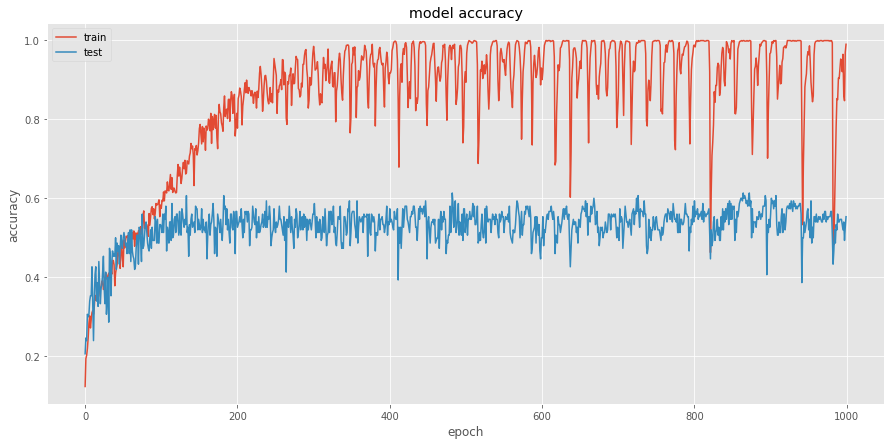

In [36]:
plt.figure(figsize=(15, 7))
plt.style.use('ggplot')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

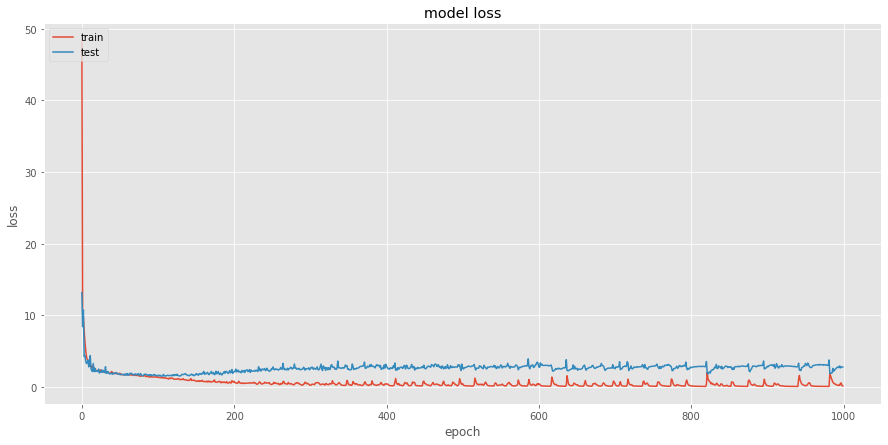

In [37]:
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Evaluate model!

In [38]:
loss = model.evaluate(x_test, y_test)


4/4 [==============================] - 0s 1ms/step - loss: 2.1484 - acc: 0.5900
